In [1]:
# This demo covers using the ClassificationThesholdTuner tool, which helps
# identify and describe thresholds that may be used for classification
# problems. 

# For simplicity, this notebook uses synthetic data. Another notebook uses
# real data. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from threshold_tuner import ClassificationThresholdTuner

# Functions to generate synthetic predictions

In [3]:
NUM_ROWS = 100_000

In [4]:
# The synthetic data consists only of true labels and predicted probabilities,
# as these are all that are needed by ClassificationThesholdTuner; it does
# not examine the original features. 

# Simple case with half the rows true 0 and half true 1. The predictions are
# well-separated. This is a basic smoke test, as any threshold in the 
# vicinity of 0.5 will perfectly separate the classes. 
def generate_data_1():
    num_rows_per_class = NUM_ROWS // 2
    np.random.seed(0)
    d = pd.DataFrame({"Y": ['A']*num_rows_per_class + ['B']*num_rows_per_class,
                  "Pred_Proba": 
                      np.random.normal(0.5, 0.1, num_rows_per_class).tolist() + \
                      np.random.normal(1.5, 0.1, num_rows_per_class).tolist()
                 })
    return d, ['A', 'B']

# Similar to generate_data_1(), but the predictions overlap more
def generate_data_2():
    num_rows_per_class = NUM_ROWS // 2
    np.random.seed(0)
    d = pd.DataFrame({"Y": ['A']*num_rows_per_class + ['B']*num_rows_per_class,
                  "Pred_Proba": 
                      np.random.normal(0.7, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(1.4, 0.3, num_rows_per_class).tolist()
                 })
    return d, ['A', 'B']

# Generate the test data

In [5]:
d, target_classes = generate_data_2()
d

,Y,Pred_Proba
0,A,1.229216
1,A,0.820047
2,A,0.993621
3,A,1.372268
4,A,1.260267
...,...,...
99995,B,1.298686
99996,B,0.791435
99997,B,1.617855
99998,B,1.049651


In [6]:
target_classes

['A', 'B']

In [7]:
# Ensure the probabilities are between 0.0 and 1.0. It is possible for the scores coming
# from MinMaxScaler to be slighly outside this range.

scaler= MinMaxScaler()
proba_cols = [x for x in d.columns if "Proba" in x]

for col_name in proba_cols:
    d[col_name] = scaler.fit_transform(d[col_name].values.reshape(-1, 1)).reshape(1, -1)[0]
    d[col_name] = [x if x <= 1.0 else 1.0 for x in d[col_name]]
    d[col_name] = [x if x >= 0.0 else 0.0 for x in d[col_name]]

In [8]:
# Set the Binary prediction column, to start, based on a threshold of 0.5

d['Pred'] = np.where(d["Pred_Proba"] > 0.50, "B", "A")
d

,Y,Pred_Proba,Pred
0,A,0.571782,B
1,A,0.450386,A
2,A,0.501884,B
3,A,0.614224,B
4,A,0.580995,B
...,...,...,...
99995,B,0.592393,B
99996,B,0.441897,A
99997,B,0.687088,B
99998,B,0.518507,B


In [9]:
d.dtypes

Y              object
Pred_Proba    float64
Pred           object
dtype: object

# Test the visualizations

In [11]:
tuner = ClassificationThresholdTuner()

,Metric,A,B,Macro
0,Precision,0.910200,0.846962,0.878581
0,Recall,0.834180,0.917700,0.875940
0,F1,0.870533,0.880913,0.875723


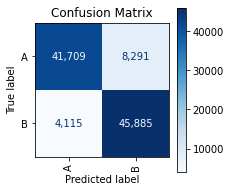

In [12]:
# Simple output based on the predicted classes

tuner.print_stats_labels(
    y_true=d["Y"], 
    target_classes=target_classes,
    y_pred=d["Pred"])

,Metric,A,B,Macro
0,Precision,0.910200,0.846962,0.878581
0,Recall,0.834180,0.917700,0.875940
0,F1,0.870533,0.880913,0.875723


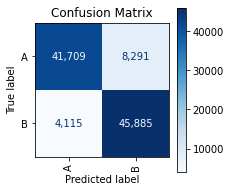

,Metric,Score
0,Brier Score,0.164794
1,AUROC,0.951993


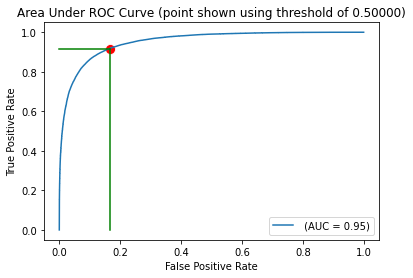

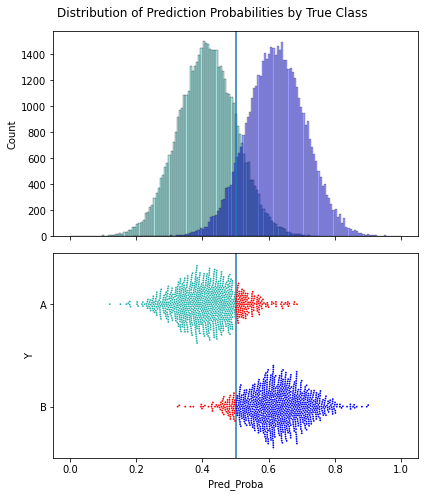

In [13]:
# Simple output based on the predicted probabilities for each class. Calling
# print_stats_proba() includes a call to print_stats_labels(), and provides 
# additional information based on the probabilities. 

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d["Pred_Proba"])

,Start Range %,End Range %,Min Probability,Max Probability,Count A,Count B,Total Count,Precision,Recall,Cumulative Count B,Cumulative Total Count,Cumulative Precision,Cumulative Recall
0,0.9,1.0,0.697954,0.980241,35,9965,10000,0.996500,0.19930,9965,10000,0.996500,0.19930
1,0.8,0.9,0.646358,0.697952,197,9803,10000,0.980300,0.19606,19768,20000,0.988400,0.39536
2,0.7,0.8,0.604022,0.646353,598,9402,10000,0.940200,0.18804,29170,30000,0.972333,0.58340
3,0.6,0.7,0.562329,0.604015,1529,8471,10000,0.847100,0.16942,37641,40000,0.941025,0.75282
4,0.5,0.6,0.518452,0.562327,3558,6442,10000,0.644200,0.12884,44083,50000,0.881660,0.88166
5,0.4,0.5,0.474919,0.518452,6465,3535,10000,0.353500,0.07070,47618,60000,0.793633,0.95236
6,0.3,0.4,0.433217,0.474907,8452,1547,9999,0.154715,0.03094,49165,69999,0.702367,0.98330
7,0.2,0.3,0.391629,0.433217,9421,580,10001,0.057994,0.01160,49745,80000,0.621812,0.99490
8,0.1,0.2,0.339510,0.391624,9786,214,10000,0.021400,0.00428,49959,90000,0.555100,0.99918
9,0.0,0.1,0.000000,0.339499,9959,40,9999,0.004000,0.00080,49999,99999,0.499995,0.99998


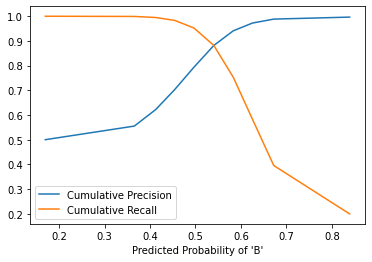

In [14]:
# Display stats about the precision & recall for various ranges of the 
# predicted probabilities.

tuner.print_stats_table(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"],
    num_ranges=10
)

# Tools to help adjust the threshold

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


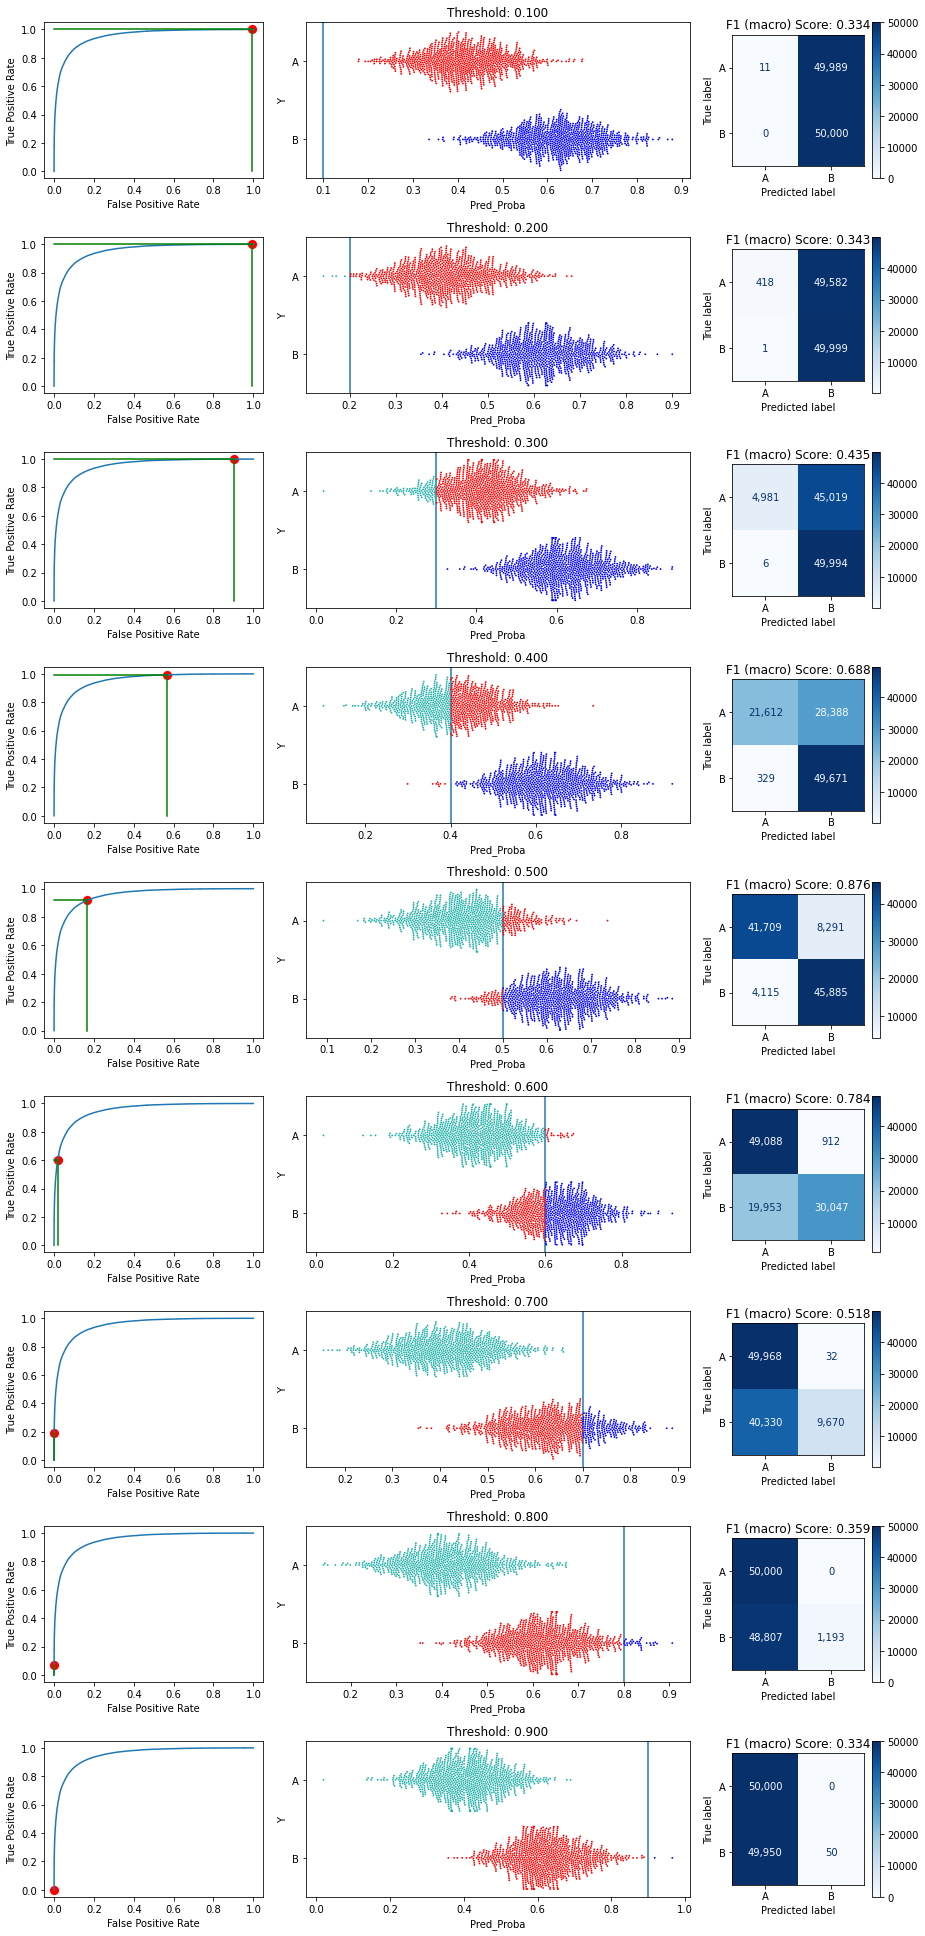

In [15]:
# View the effect of different thresholds for a specified
# set of thresholds. This uses the default set of 0.1, 0.2,
# 0.3 ... up to 0.9. Misclassified records are shown in red.
# It will predict anything right of the threshold as the positive
# class and anything to the right as the negative class. 

tuner.plot_by_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.04s/it]


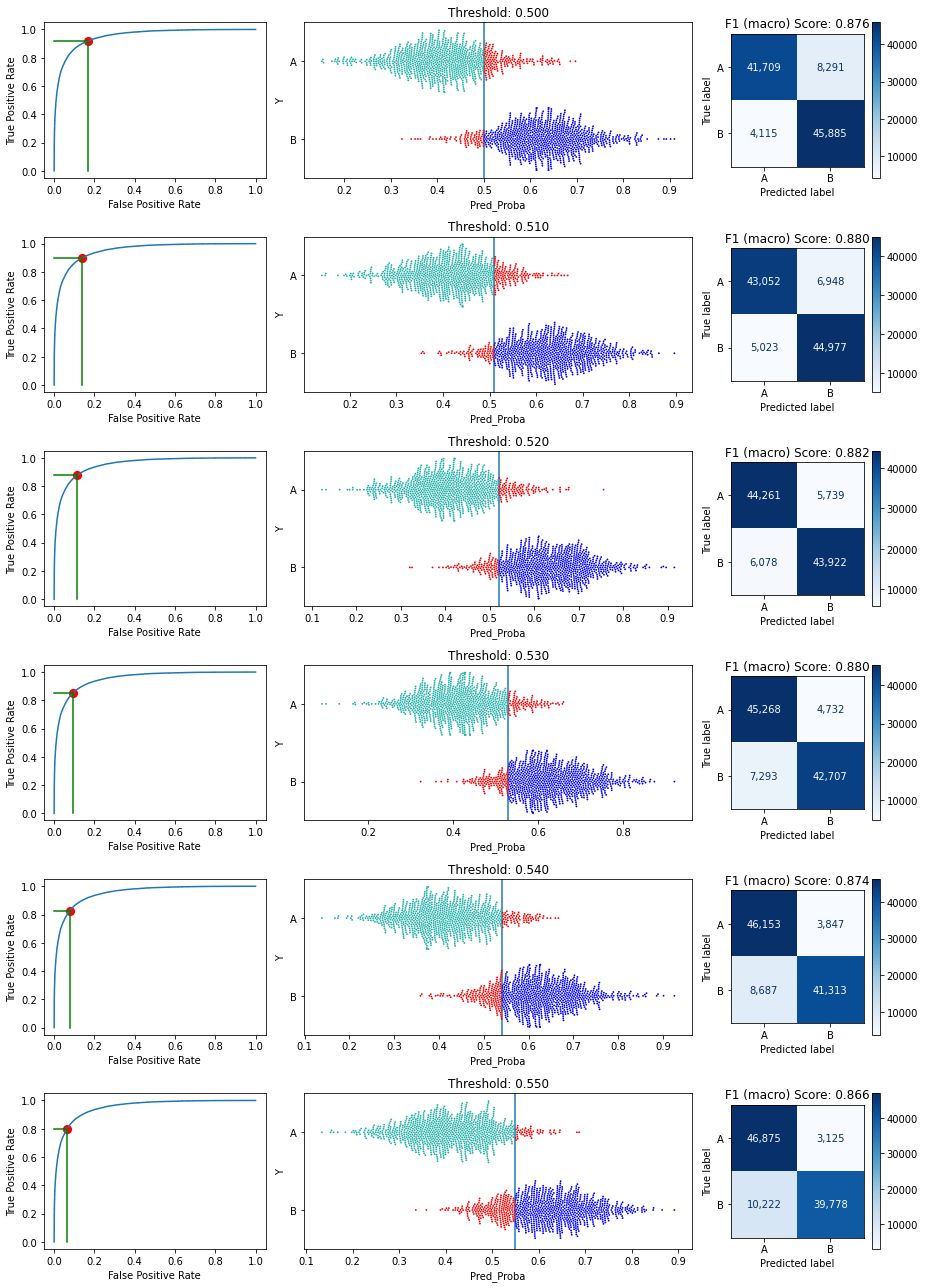

In [16]:
# View a reduced set of thresholds. This is an example
# specifying the start, end, and num_steps parameters.

tuner.plot_by_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"], 
    start=0.50, end=0.55, num_steps=6)

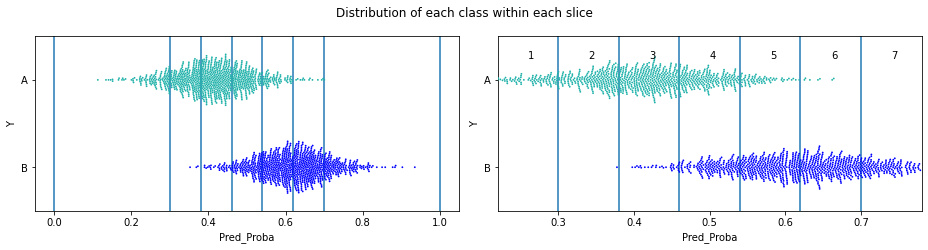

,Slice,Min Prob,Max Prob,A,B,Total,Fraction A,Fraction B
0,1,0.00,0.30,4980,6,4986,0.998797,0.001203
1,2,0.30,0.38,12332,169,12501,0.986481,0.013519
2,3,0.38,0.46,17529,1464,18993,0.922919,0.077081
3,4,0.46,0.54,11311,7048,18359,0.616101,0.383899
4,5,0.54,0.62,3310,15688,18998,0.174229,0.825771
5,6,0.62,0.70,505,15955,16460,0.030680,0.969320
6,7,0.70,1.00,32,9670,9702,0.003298,0.996702


In [17]:
# To compare choices for thresholds, we look closer at the slices
# between a set of potential thresholds. Here we specify 5 slices.
# The table output will also include the ranges before and after
# these, so 7 slices in total.

tuner.describe_slices(    
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"], 
    start=0.3, end=0.7, num_slices=5)

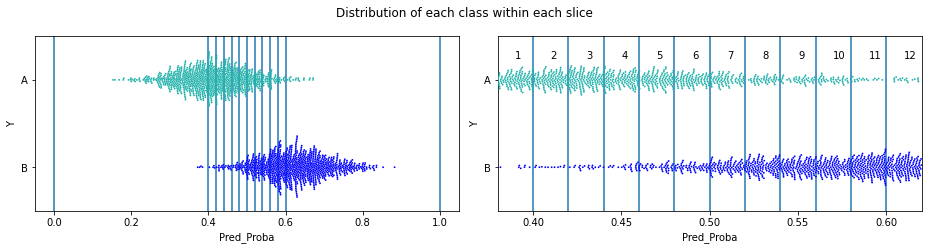

,Slice,Min Prob,Max Prob,A,B,Total,Fraction A,Fraction B
0,1,0.00,0.40,21611,329,21940,0.985005,0.014995
1,2,0.40,0.42,4611,228,4839,0.952883,0.047117
2,3,0.42,0.44,4447,439,4886,0.910151,0.089849
3,4,0.44,0.46,4172,643,4815,0.866459,0.133541
4,5,0.46,0.48,3626,1029,4655,0.778947,0.221053
5,6,0.48,0.50,3241,1447,4688,0.691340,0.308660
6,7,0.50,0.52,2552,1963,4515,0.565227,0.434773
7,8,0.52,0.54,1892,2609,4501,0.420351,0.579649
8,9,0.54,0.56,1351,3248,4599,0.293760,0.706240
9,10,0.56,0.58,992,3753,4745,0.209062,0.790938


In [18]:
# View a smaller range of potential thresholds more closely.

tuner.describe_slices(    
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"], 
    start=0.4, end=0.6, num_slices=10)

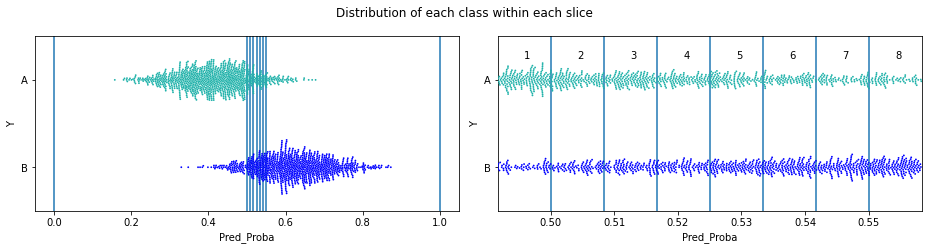

,Slice,Min Prob,Max Prob,A,B,Total,Fraction A,Fraction B
0,1,0.000000,0.500000,41708,4115,45823,0.910198,0.089802
1,2,0.500000,0.508333,1144,763,1907,0.599895,0.400105
2,3,0.508333,0.516667,1028,849,1877,0.547682,0.452318
3,4,0.516667,0.525000,906,919,1825,0.496438,0.503562
4,5,0.525000,0.533333,784,1093,1877,0.417688,0.582312
5,6,0.533333,0.541667,720,1203,1923,0.374415,0.625585
6,7,0.541667,0.550000,584,1280,1864,0.313305,0.686695
7,8,0.550000,1.000000,3125,39778,42903,0.072839,0.927161


In [19]:
# Zoom in further

tuner.describe_slices(    
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"], 
    start=0.5, end=0.55, num_slices=6)

# Select the optimal threshold

In [20]:
# Allow ClassificationThesholdTuner to identify the best threshold optimizing
# for a specified metric, in this example, the F1 macro score.

from sklearn.metrics import f1_score

best_threshold = tuner.tune_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"],
    metric=f1_score,
    average='macro',
    higher_is_better=True,
    max_iterations=5
)
best_threshold

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.12s/it]


0.5199100000000003

In [21]:
tuned_pred = tuner.get_predictions(target_classes, d["Pred_Proba"], None, best_threshold)

# Show the first 10 predictions
tuned_pred[:10]

['B', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'A']

# Re-display the metrics with the optimal threshold

,Metric,A,B,Macro
0,Precision,0.879464,0.884307,0.881885
0,Recall,0.885040,0.878700,0.881870
0,F1,0.882243,0.881494,0.881869


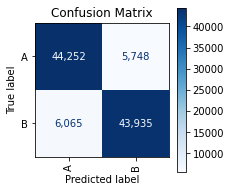

In [22]:
# We can see, with the optimized threshold, the F1 macro score 
# increased from about 0.87 to about 0.88 (results will vary slightly 
# each run)

d['Pred'] = np.where(d["Pred_Proba"] > best_threshold, "B", "A")
    
tuner.print_stats_labels(
    y_true=d["Y"], 
    target_classes=target_classes,
    y_pred=d["Pred"])    

,Metric,A,B,Macro
0,Precision,0.879464,0.884307,0.881885
0,Recall,0.885040,0.878700,0.881870
0,F1,0.882243,0.881494,0.881869


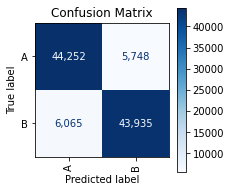

,Metric,Score
0,Brier Score,0.164794
1,AUROC,0.951993


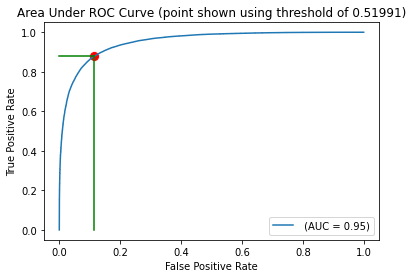

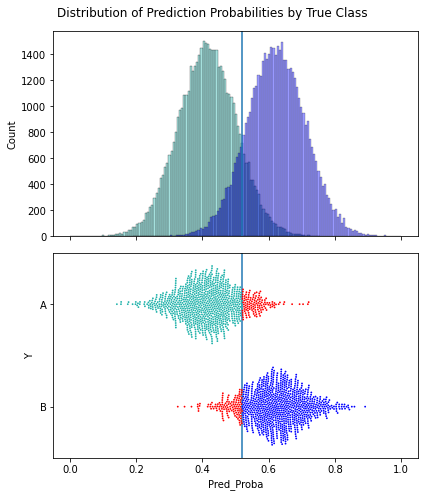

In [23]:
# Call print_stats_proba() again, this time with the optimal threshold.
# The threshold is simply drawn on the plots to provide some understanding
# of the threshold. 

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d["Pred_Proba"],
    thresholds=best_threshold
)  

# Tuning to maximize binary F1 Score

In [24]:
from sklearn.metrics import f1_score

# This gives an example of optimizing for a different metric. Usually,
# a different threshold will be discovered. 
# In this case, the pos_label must be specified as well.

best_threshold = tuner.tune_threshold(
    y_true=d['Y'],
    target_classes=target_classes,
    y_pred_proba=d["Pred_Proba"],
    metric=f1_score,
    average='binary',
    pos_label='B',
    higher_is_better=True,
    max_iterations=5
)
best_threshold

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.11s/it]


0.4991800000000002